In [1]:
import os
import sys

from torch import load, numel

sys.path.insert(0, '..')
from lib.utils import read_model_params, get_which_model_from_params_fname

model_params_fname = '../DNNs/20181203090415_11_evaluated/k_4/model_params.json'
model_fname = '../DNNs/20181203090415_11_evaluated/k_4/model.dat'


In [2]:
# # Check all the layer sizes just from the model.dat
# tensor_dict = load(model_fname, map_location='cpu')
# tensor_list = list(tensor_dict.items())
# for layer_tensor_name, tensor in tensor_list:
#     print('Layer {}: {} size'.format(layer_tensor_name, tensor.size()))

In [3]:
model, params = get_which_model_from_params_fname(model_params_fname, return_params=True)

# print(model)
model.load_state_dict(load(os.path.join(os.path.dirname(model_params_fname), 'model.dat'), map_location='cpu'))
model.eval()

get_which_model_from_params_fname: input_channel = 1


LeNet_1D(
  (conv1): Conv1d(1, 45, kernel_size=(17,), stride=(1,))
  (conv1_drop): Dropout2d(p=0.0)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(45, 35, kernel_size=(12,), stride=(1,))
  (conv2_drop): Dropout2d(p=0.514948804688646)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fcs): FullyConnectedNet(
    (layers): ModuleList(
      (0): Linear(in_features=805, out_features=109, bias=True)
      (1): Linear(in_features=109, out_features=109, bias=True)
      (2): Linear(in_features=109, out_features=130, bias=True)
    )
    (batch_norm_layers): ModuleList(
      (0): BatchNorm1d(109, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(109, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU()
    (dropout): Dropout(p=0.8559119274655482)
  )
)

In [4]:
# params

In [5]:
import json
from pprint import pprint

with open(model_params_fname) as f:
    pprint(json.load(f))



{'batch_norm': 1,
 'batch_size': 32,
 'conv1_dropout': 0.0,
 'conv1_kernel_size': 17,
 'conv1_num_kernels': 45,
 'conv1_stride': 1,
 'conv2_dropout': 0.514948804688646,
 'conv2_kernel_size': 12,
 'conv2_num_kernels': 35,
 'conv2_stride': 1,
 'cost_function': 'SmoothL1',
 'cuda': 1,
 'data_is_target': 0,
 'data_noise_gaussian': 1,
 'data_train': '/home/chenz/Downloads/20180402_L74_70mm/train_2.h5',
 'data_val': '/home/chenz/Downloads/20180402_L74_70mm/val_2.h5',
 'fcs_dropout': 0.8559119274655482,
 'fcs_hidden_size': 109,
 'fcs_num_hidden_layers': 2,
 'input_channel': 1,
 'k': 4,
 'learning_rate': 0.0001802763794651928,
 'momentum': None,
 'optimizer': 'Adam',
 'output_size': 130,
 'patience': 20,
 'pool1_kernel_size': 2,
 'pool1_stride': 2,
 'pool2_kernel_size': 2,
 'pool2_stride': 2,
 'pooling_method': 'max',
 'save_dir': 'DNNs/20181203090415_11_created/k_4',
 'save_initial': 0,
 'use_pooling': 1,
 'weight_decay': 0}


In [6]:
import numpy as np
from scipy import io
import h5py
import matplotlib.pyplot as plt

# old_stft = io.loadmat('old_stft.mat')# , {'new_stft_real': new_stft_real, 'new_stft_imag': new_stft_imag})old_stft = h5py.File("old_stft.mat", "r")
old_stft = h5py.File("old_stft.mat", "r")
stft_real_old = np.asarray(old_stft['old_stft_real'])
stft_imag_old = np.asarray(old_stft['old_stft_imag'])
old_stft.close()

# save new stft data
new_stft = io.loadmat('new_stft.mat')# , {'new_stft_real': new_stft_real, 'new_stft_imag': new_stft_imag})
stft_real_new = new_stft['stft_real_new']
stft_imag_new = new_stft['stft_imag_new']


In [7]:
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

# model.conv1.register_forward_hook(get_activation('conv1'))

# act = activation['conv1'].squeeze()
# fig, axarr = plt.subplots(act.size(0))
# for idx in range(act.size(0)):
#     axarr[idx].imshow(act[idx])

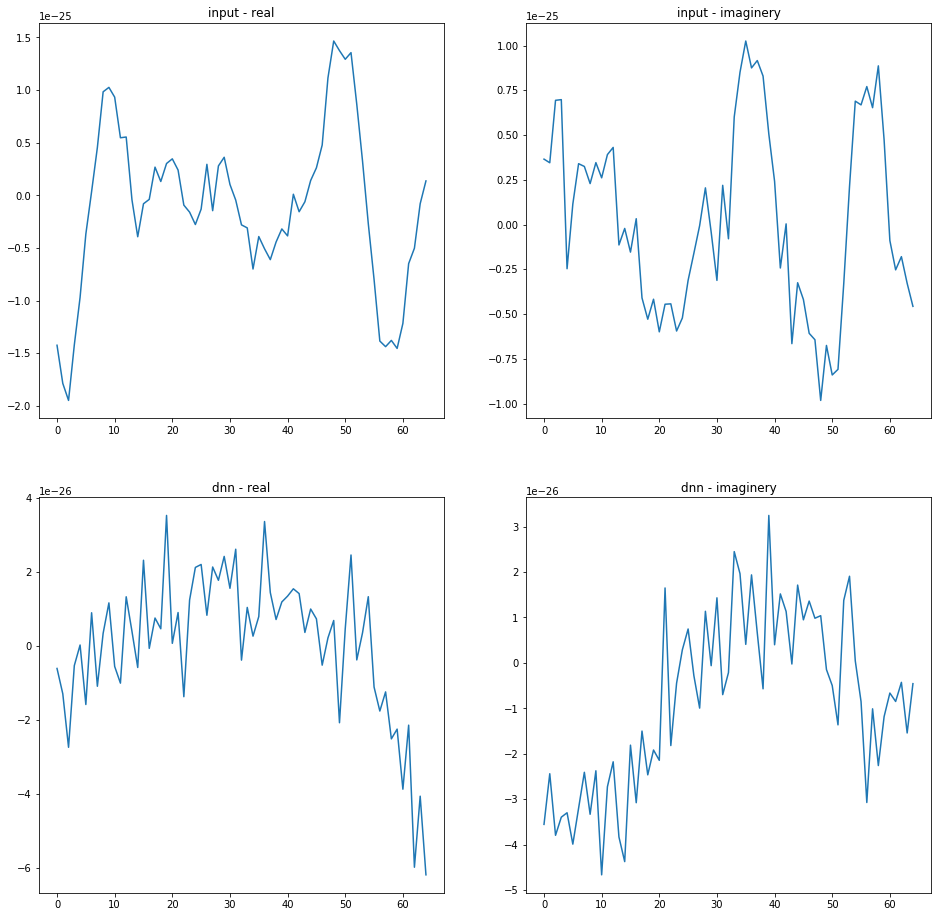

In [8]:
beam_num = 24
segment_num = 63
k = 4

fig, axes = plt.subplots(2, 2, figsize = (16,16))
axes[0, 0].plot(stft_real_old[beam_num, :, segment_num, k]) # is this correct?
axes[0, 0].set_title('input - real')
axes[0, 1].plot(stft_imag_old[beam_num, :, segment_num, k])
axes[0, 1].set_title('input - imaginery')

axes[1, 0].plot(stft_real_new[beam_num, :, segment_num, k]) # is this correct?
axes[1, 0].set_title('dnn - real')
axes[1, 1].plot(stft_imag_new[beam_num, :, segment_num, k])
axes[1, 1].set_title('dnn - imaginery')
plt.show()

In [9]:
import h5py
import numpy as np
import os
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable

import sys
sys.path.insert(0, '..')
# from lib.utils import load_model
# from lib.lenet import LeNet


def see_sample(sample_index):
#     model = '20181203090415_11_evaluated'
    k = 4
    n_scat = 1 # [1, 2, 3]


    home = os.path.expanduser('~')
    fname = os.path.join(home,'Downloads', '20180402_L74_70mm', 'train_' + str(n_scat) + '.h5')


    # check if files exist
#     if not os.path.isfile(fname):
#         raise IOError(fname + ' does not exist.')

    # Open file
    with h5py.File(fname, 'r') as f:

        # Get number of samples available for each type
        real_available = f['/' + str(k) + '/X/real'].shape[0]
        imag_available = f['/' + str(k) + '/X/imag'].shape[0]
        samples_available = min(real_available, imag_available)


        # load the data
        inputs_real = f['/' + str(k) + '/X/real'][sample_index]
        inputs_imag = f['/' + str(k) + '/X/imag'][sample_index]

        targets_real = f['/' + str(k) + '/Y/real'][sample_index]
        targets_imag = f['/' + str(k) + '/Y/imag'][sample_index]


    inputs = np.hstack([inputs_real, inputs_imag])
    inputs_all_plot = inputs.copy()
#     plt.figure(figsize=(16, 16))
#     plt.plot(inputs_all_plot)
#     plt.ylim(-1, 1)
    inputs = inputs[np.newaxis, :]
    inputs = Variable(torch.from_numpy(inputs).float())

    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    model.conv1.register_forward_hook(get_activation('conv1'))

    


    print(inputs.shape)
    x = inputs.cpu().data.numpy()
    
    x_real = x[0, :65]
    x_imag = x[0, 65:]


#     model_cnn = get_which_(os.path.join('..', 'DNNs', model, 'k_' + str(k), 'model_params.json'))
    y_hat = model(inputs).cpu().data.numpy()
    
#     print(activation['conv1'].shape)
    act = activation['conv1'].squeeze()
#     print(act.shape)
    fig, axarr = plt.subplots(act.size(0), figsize=(16, 100))
    for idx in range(act.size(0)):
#         print(act[idx].shape)
        axarr[idx].plot(act[idx].numpy())


    y_hat_real = y_hat[0, :65]
    y_hat_imag = y_hat[0, 65:]
    
#     print('y_hat.shape', y_hat.shape)
#     plt.figure(figsize=(16, 16))
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    axes[0].plot(inputs_all_plot)
    axes[1].plot(y_hat.squeeze())
#     plt.plot()
#     plt.ylim(-1, 1)


    fig, axes = plt.subplots(3, 2, figsize=(16,24))
#     ylim = (-2, 2)


    axes[0, 0].plot(x_real)
    axes[0, 0].set_title('x - real')
#     axes[0, 0].set_ylim(*ylim)
    axes[0, 1].plot(x_imag)
    axes[0, 1].set_title('x - imag')
#     axes[0, 1].set_ylim(*ylim)

    axes[1, 0].plot(targets_real)
    axes[1, 0].set_title('y - real')
#     axes[1, 0].set_ylim(*ylim)
    axes[1, 1].plot(targets_imag)
    axes[1, 1].set_title('y - imag')
#     axes[1, 1].set_ylim(*ylim)

    axes[2, 0].plot(y_hat_real)
    axes[2, 0].set_title('y_hat_cnn - real')
#     axes[2, 0].set_ylim(*ylim)
    axes[2, 1].plot(y_hat_imag)
    axes[2, 1].set_title('y_hat_cnn - imag')
#     axes[2, 1].set_ylim(*ylim)

    plt.show()

torch.Size([1, 130])


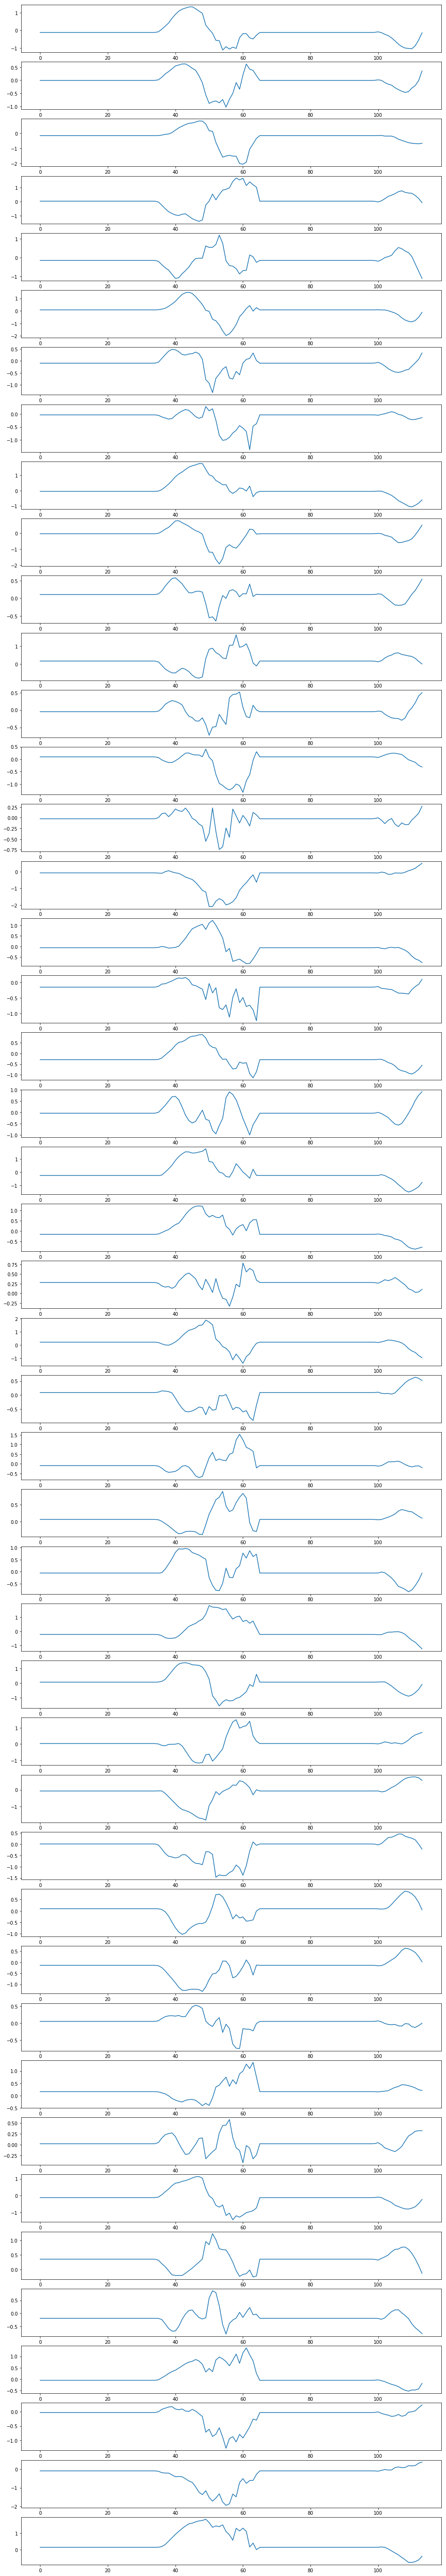

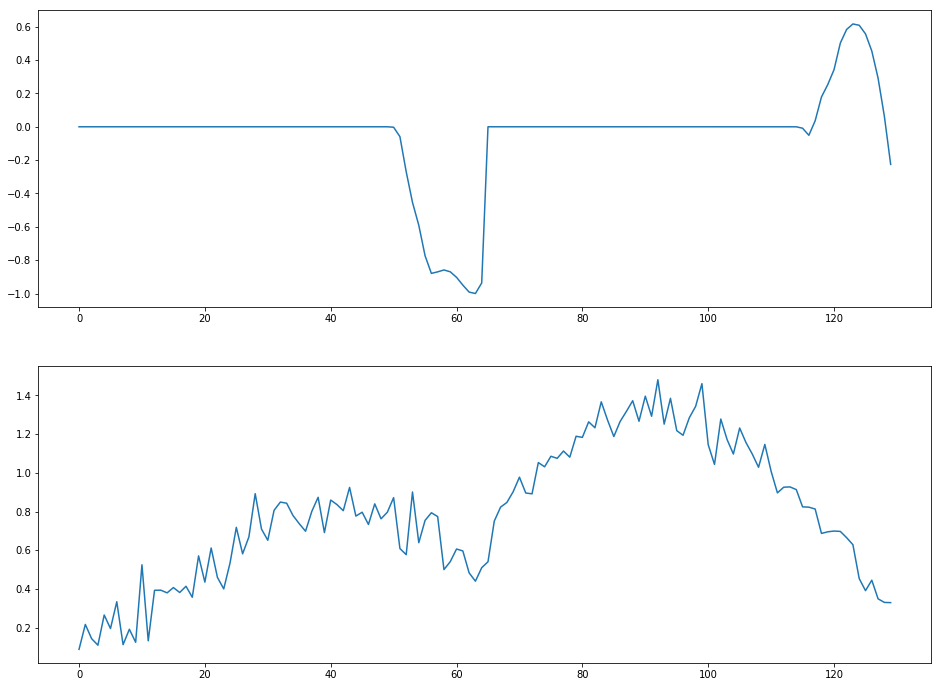

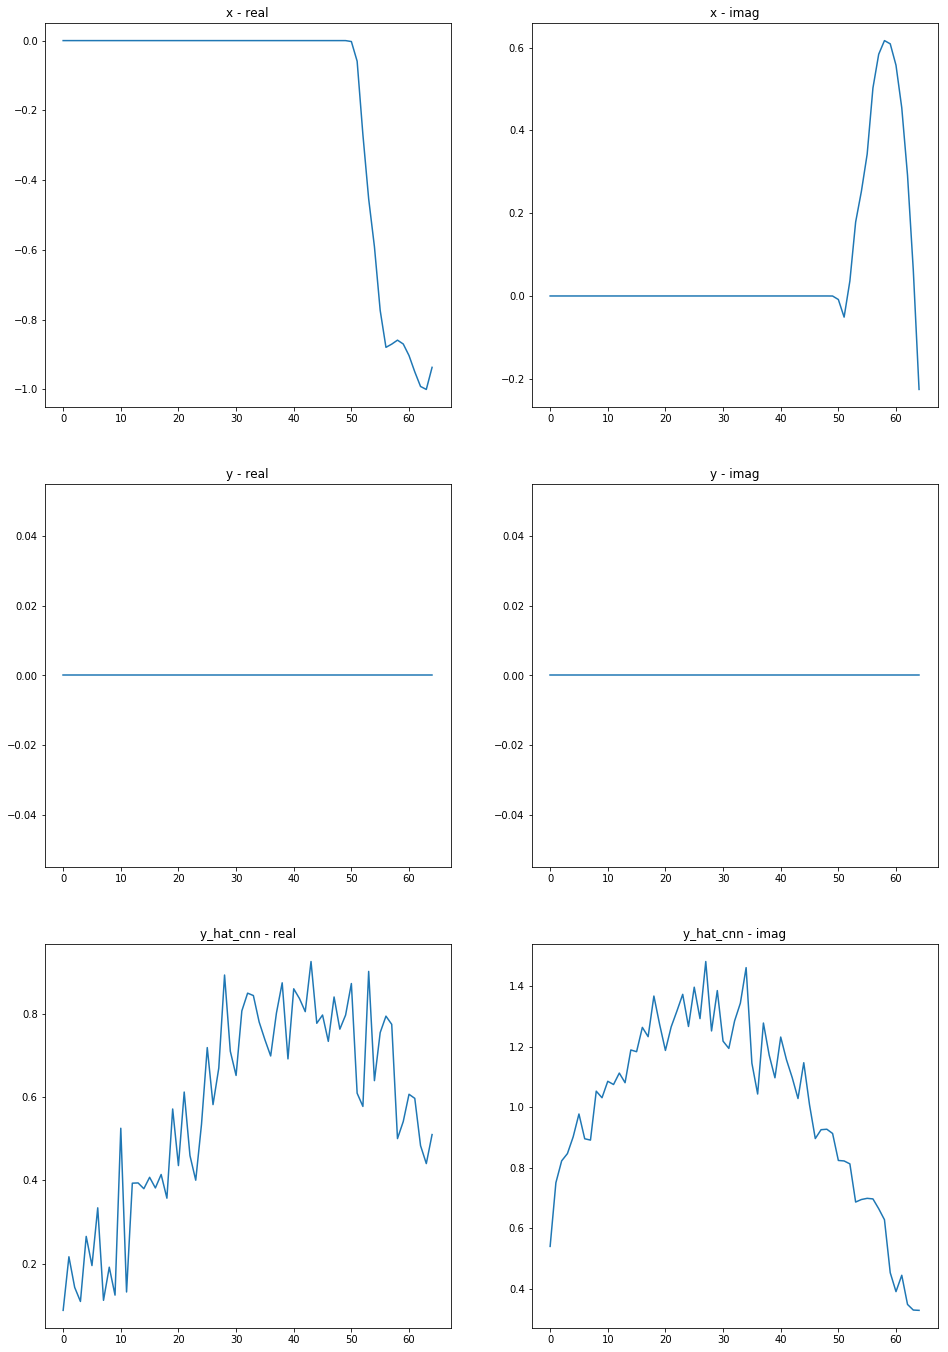

In [10]:
see_sample(0)

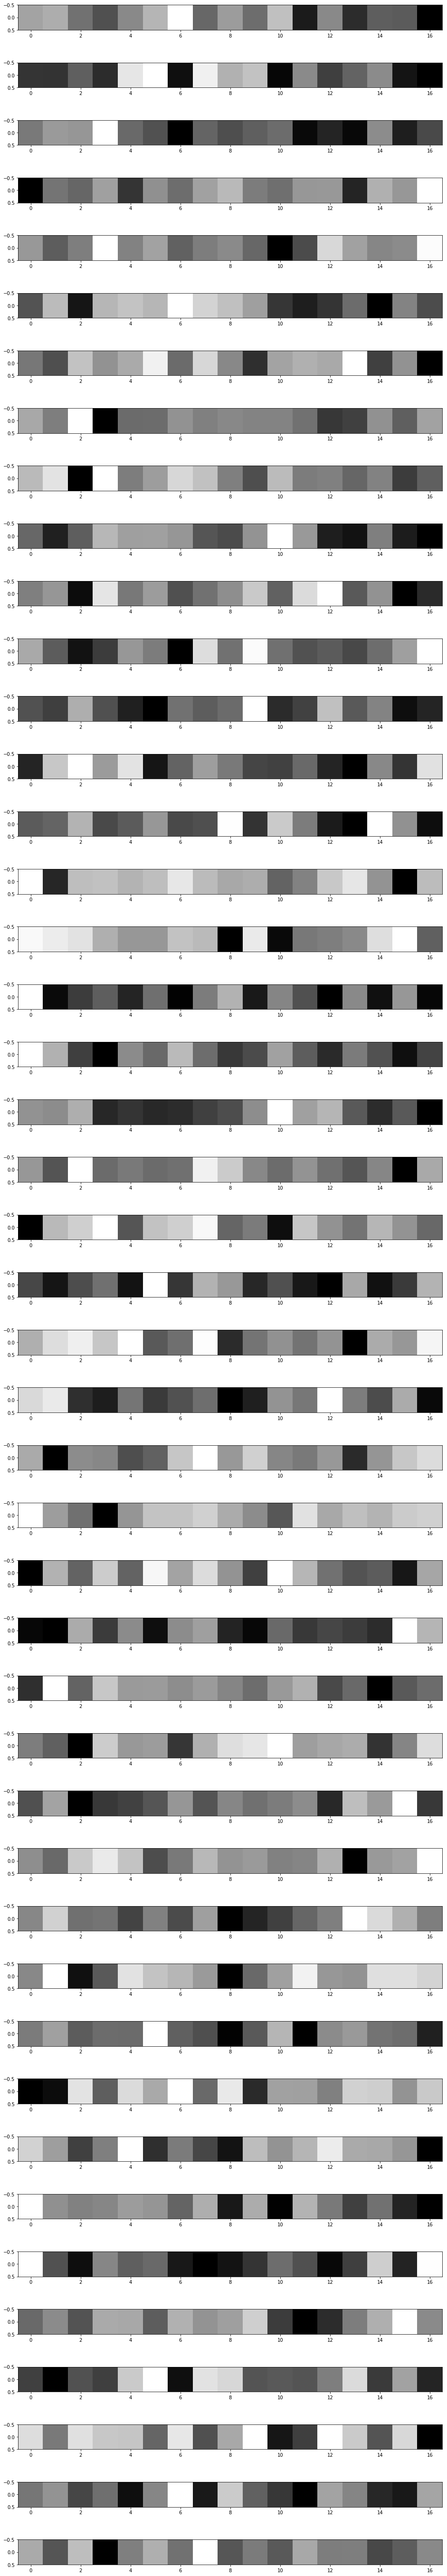

In [11]:
def print_model_kernel_weights(model):
    kernels = model.conv1.weight.detach()
    fig, axarr = plt.subplots(kernels.size(0), figsize=(16, 100))
    for idx in range(kernels.size(0)):
        axarr[idx].imshow(kernels[idx], cmap='gray')
        
        
print_model_kernel_weights(model)

torch.Size([1, 130])


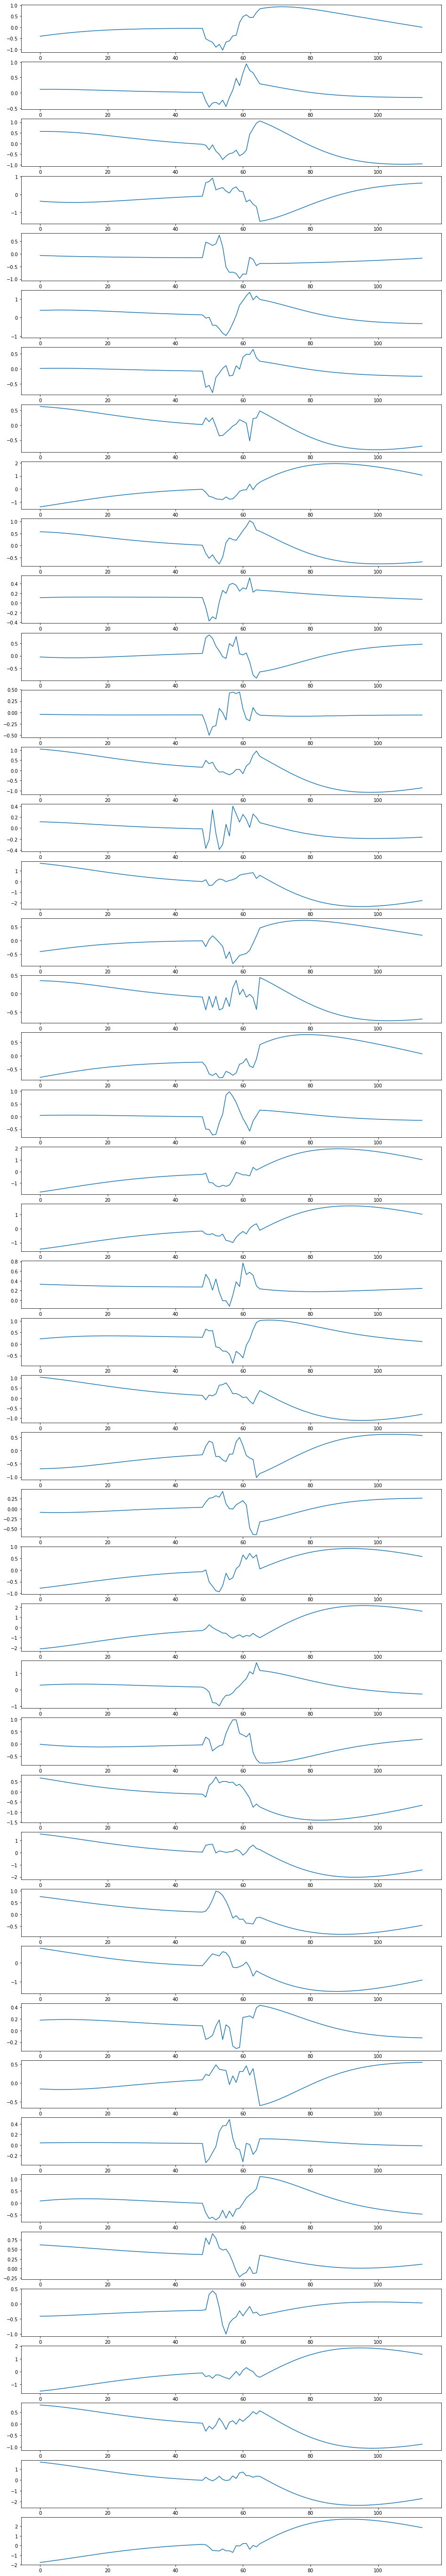

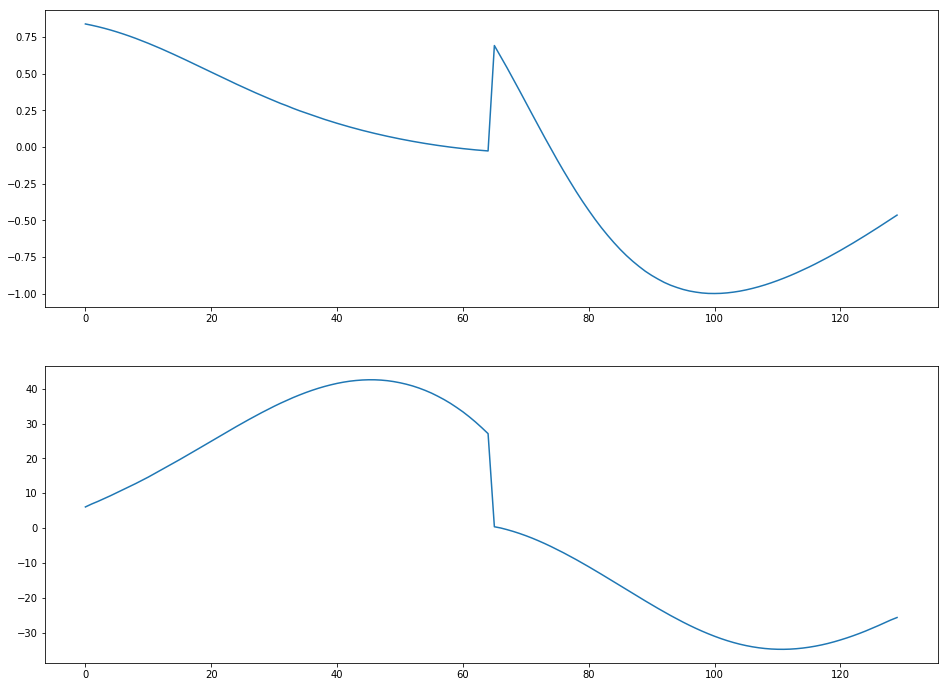

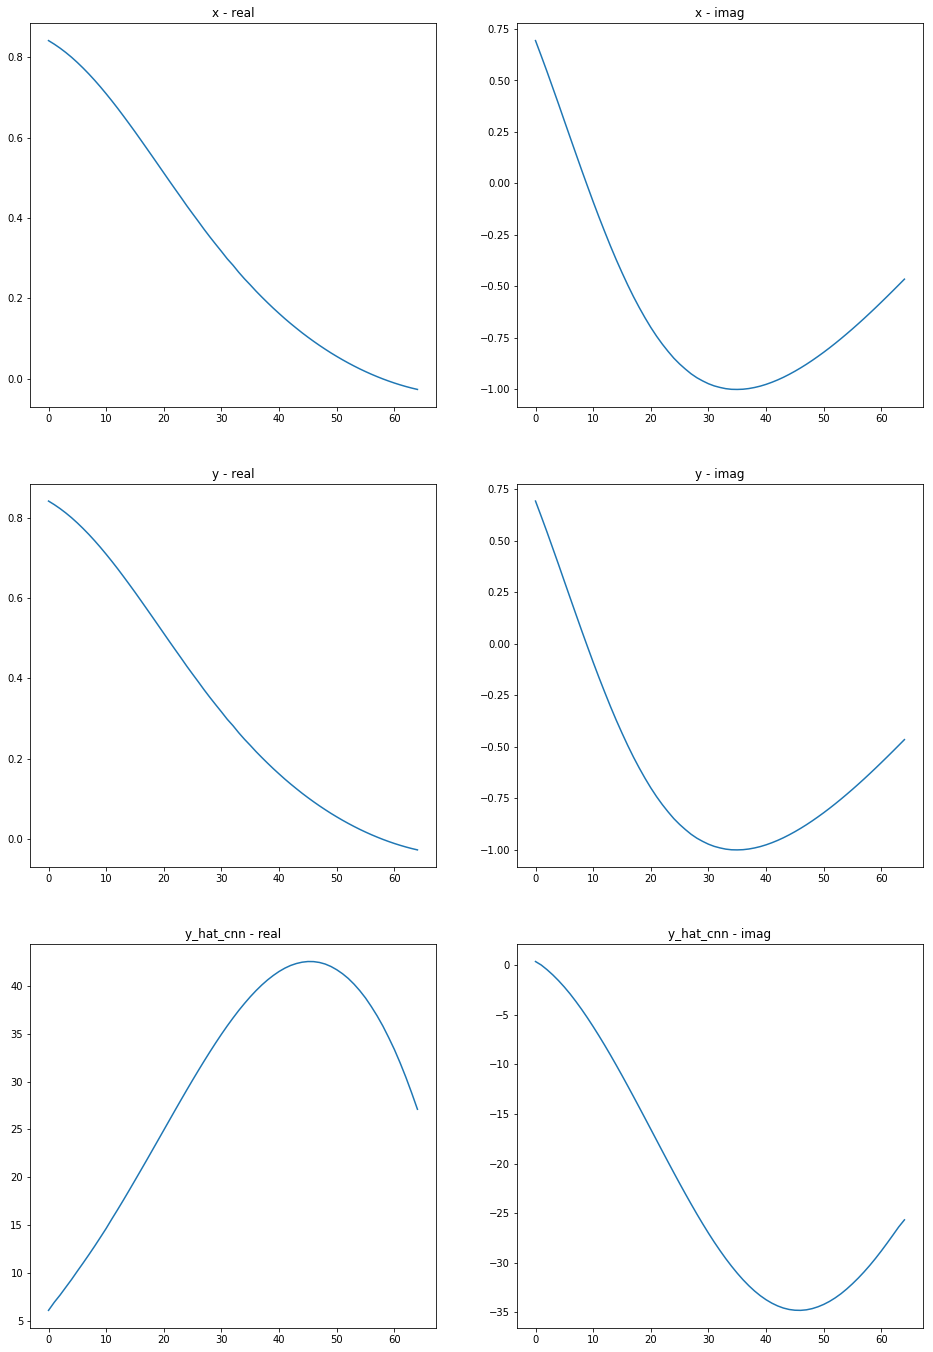

In [12]:
# Bad
see_sample(5)

torch.Size([1, 130])


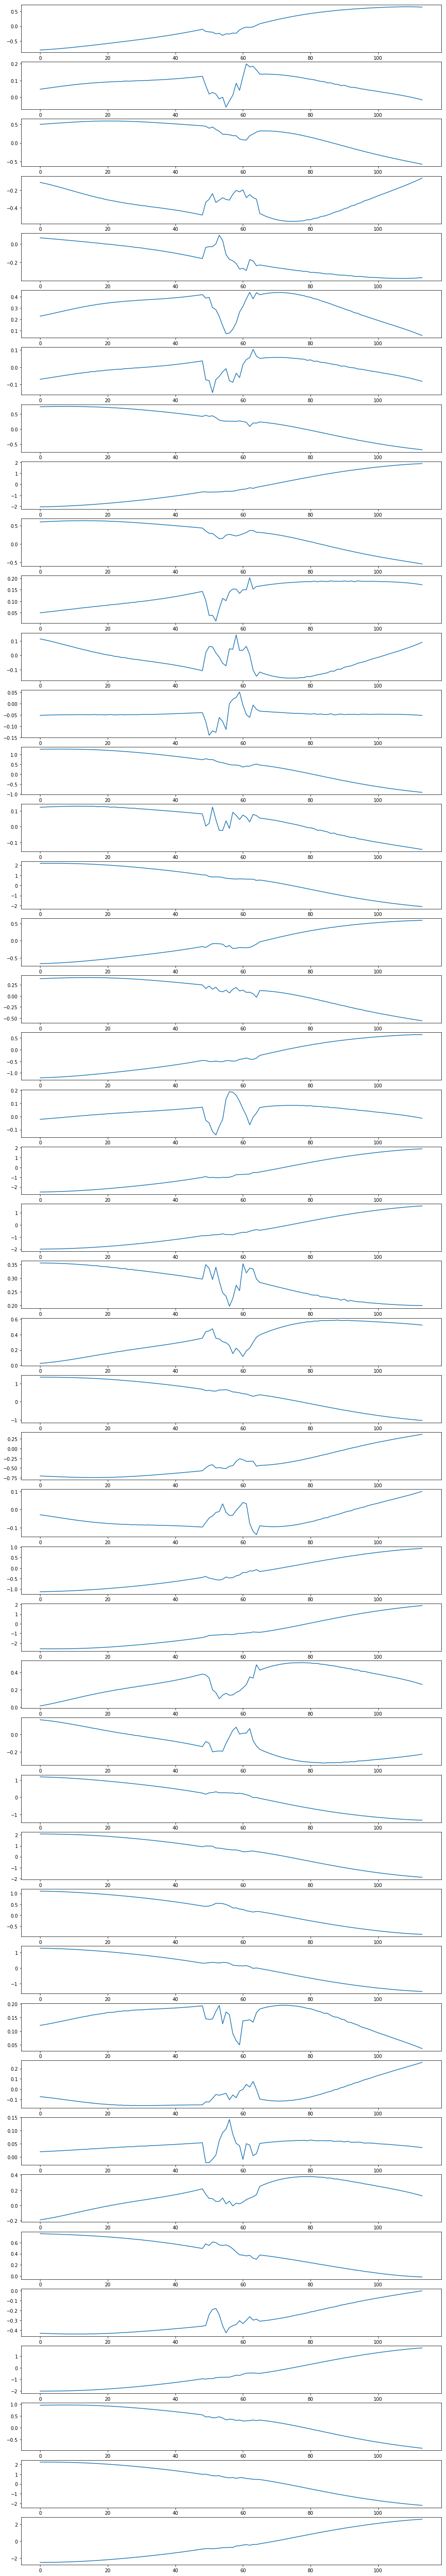

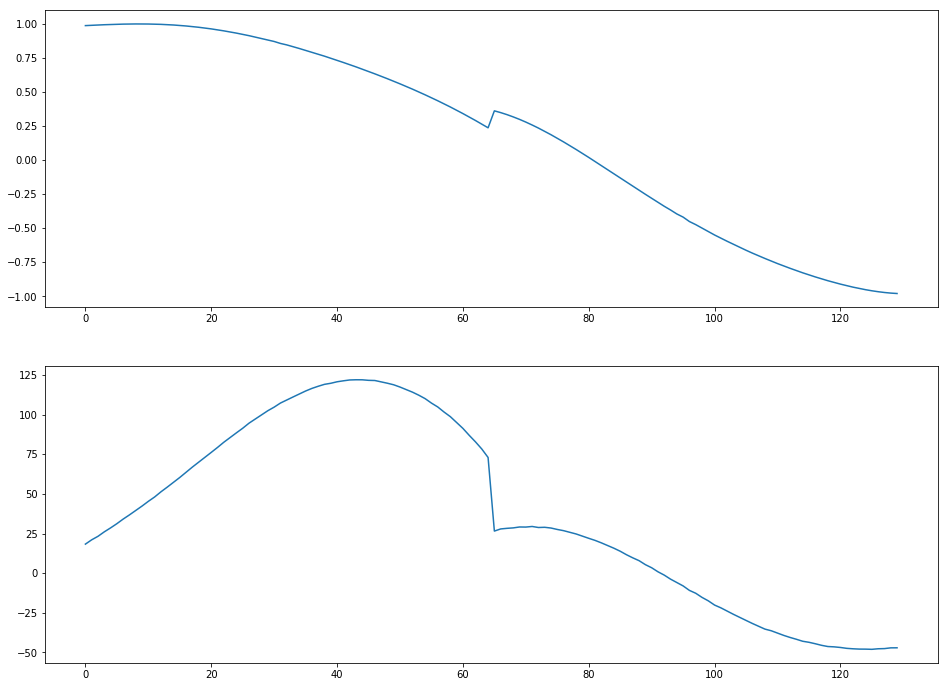

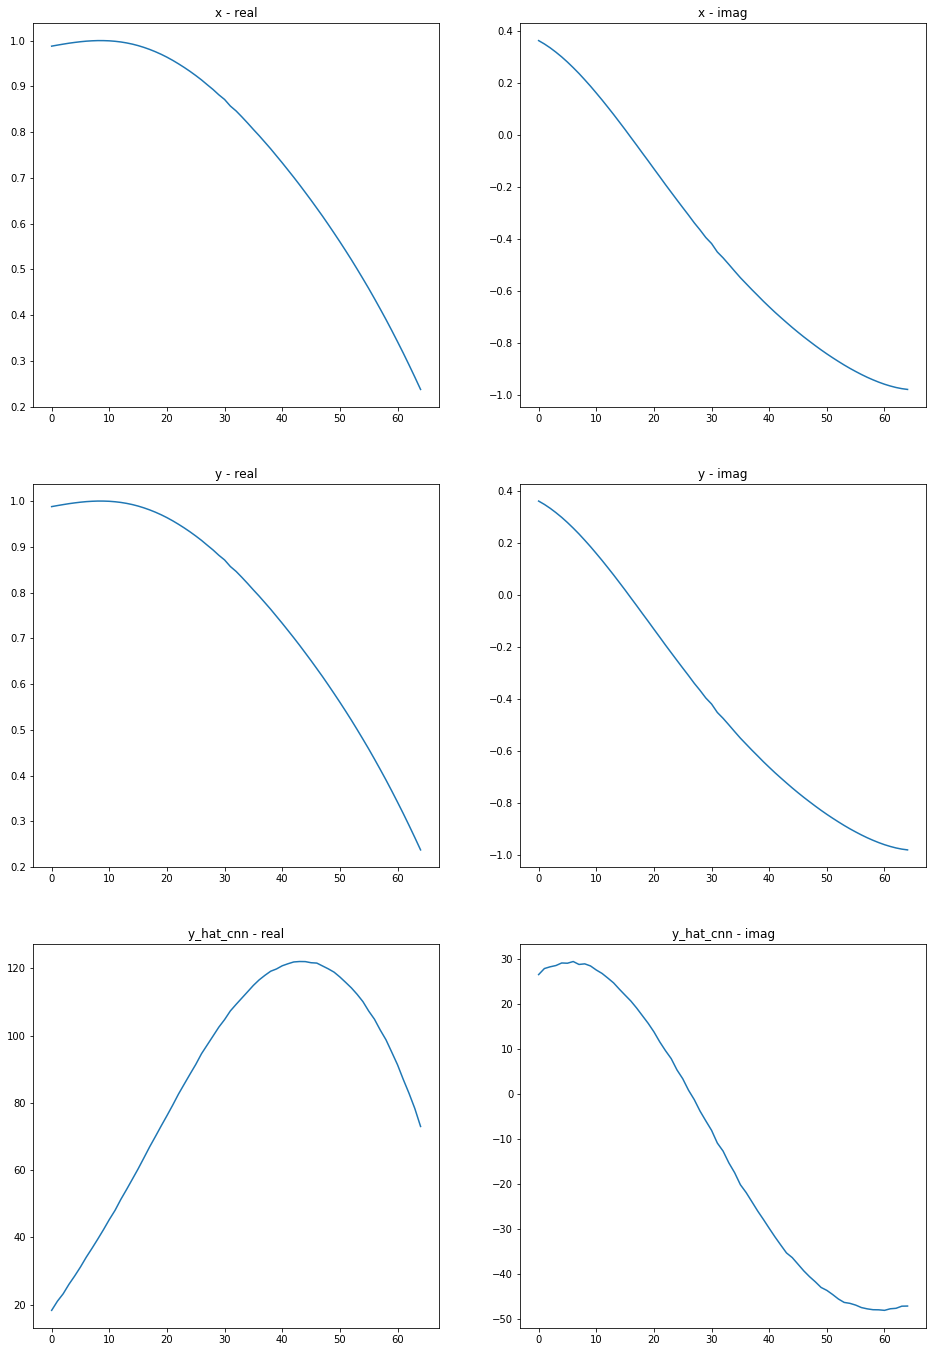

In [13]:
see_sample(6)